<h1><strong>Downsampling Experiment</strong></h1>

In [1]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<module 'score' from '/home/mtemoschenko/TFE/score.py'>

<h2>Load Model</h2>

In [2]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth"

In [3]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

Using device: cuda
Spatial Encoding Shape : torch.Size([4, 64, 64])
Channels : 24


In [4]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_277922/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth, trained until epoch 310


<h2> A(x_(x(t)) </h2>

In [5]:
def downscale(batch, mask, patch_size, device='cpu'):
    if batch.shape[0] == 1 and batch.dim() == 5:
        return batch.squeeze(0)
    print(f"batch : {batch.shape}")
    B1, B2, H, W = batch.shape
    new_H, new_W = H // patch_size, W // patch_size
    
    patches = batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # (B1, B2, new_H, new_W, patch_size, patch_size)
    print(mask.shape)
    myMask = mask[0]
    mask_patches = myMask.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
    print(patches.shape)
    print(mask_patches.shape)
    valid_patches = patches * mask_patches.unsqueeze(0).unsqueeze(0)
    valid_counts = mask_patches.sum(dim=(-2, -1), keepdim=True)
    
    valid_counts = torch.where(valid_counts == 0, torch.tensor(1, device=device), valid_counts)
    downscaled_grid = valid_patches.sum(dim=(-2, -1)) / valid_counts.squeeze(-1).squeeze(-1)
    downscaled_mask = mask_patches.any(dim=(-2, -1))
    print(downscaled_mask.shape)
    
    upsampled_batch = downscaled_grid.repeat_interleave(patch_size, dim=-1).repeat_interleave(patch_size, dim=-2)
    upsampled_mask = downscaled_mask.repeat_interleave(patch_size, dim=-1).repeat_interleave(patch_size, dim=-2)
    upsampled_batch = upsampled_batch * mask
    return upsampled_batch

batch : torch.Size([5, 24, 64, 64])
torch.Size([1, 64, 64])
torch.Size([5, 24, 8, 8, 8, 8])
torch.Size([8, 8, 8, 8])
torch.Size([8, 8])
torch.Size([10, 24, 64, 64])
T2m  Mean : 5.585689544677734, Var: 1.0696463584899902
U10m  Mean : 1.867605447769165, Var: 0.8774381279945374
T2m  Mean : 5.585689067840576, Var: 0.9875468015670776
U10m  Mean : 1.867605447769165, Var: 0.7887074947357178
T2m  Mean : 16.295995712280273, Var: 2.1350491046905518
U10m  Mean : 3.600388765335083, Var: 0.9680773019790649
T2m  Mean : 16.295995712280273, Var: 2.0365562438964844
U10m  Mean : 3.600388765335083, Var: 0.7288768291473389
T2m  Mean : 5.867013454437256, Var: 1.3515688180923462
U10m  Mean : 4.506048679351807, Var: 1.4614200592041016
T2m  Mean : 5.867013454437256, Var: 1.2987223863601685
U10m  Mean : 4.506048679351807, Var: 1.3181744813919067
T2m  Mean : -2.1947085857391357, Var: 1.1976141929626465
U10m  Mean : 4.461900234222412, Var: 1.1472282409667969
T2m  Mean : -2.1947085857391357, Var: 1.12671709060668

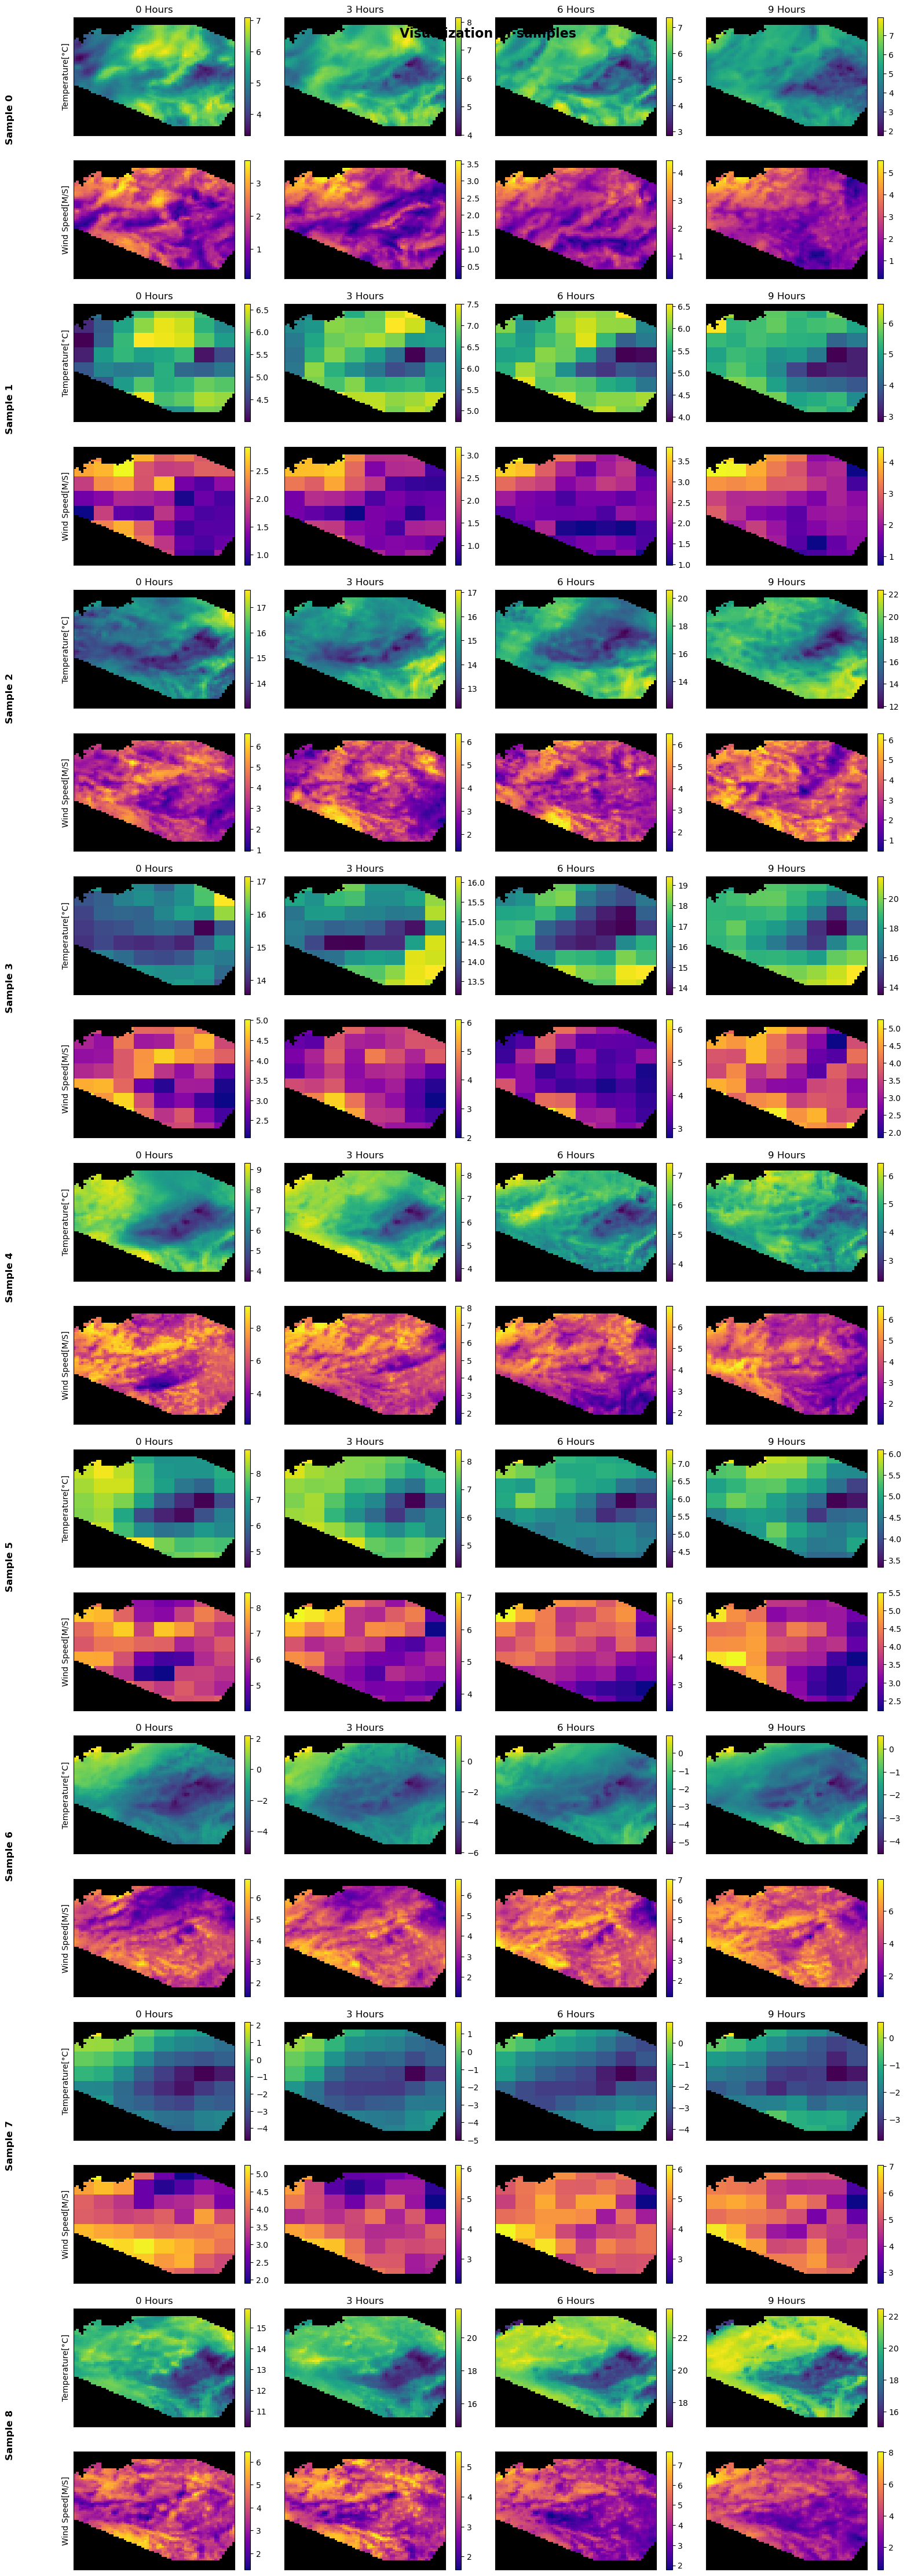

In [6]:
batch, dic = next(iter(testloader))
batch = batch.cpu()
new_tensor = torch.stack((batch,downscale(batch,mask_cpu,8)), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)


batch : torch.Size([5, 24, 64, 64])
torch.Size([1, 64, 64])
torch.Size([5, 24, 1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1])
torch.Size([5, 24, 64, 64])
T2m  Mean : -1.272935390472412, Var: 0.3739573359489441
U10m  Mean : 3.84773588180542, Var: 0.21637943387031555
T2m  Mean : 15.995467185974121, Var: 0.8974739909172058
U10m  Mean : 3.8447959423065186, Var: 0.247441366314888
T2m  Mean : 12.265220642089844, Var: 0.884822428226471
U10m  Mean : 3.7370569705963135, Var: 0.13263386487960815


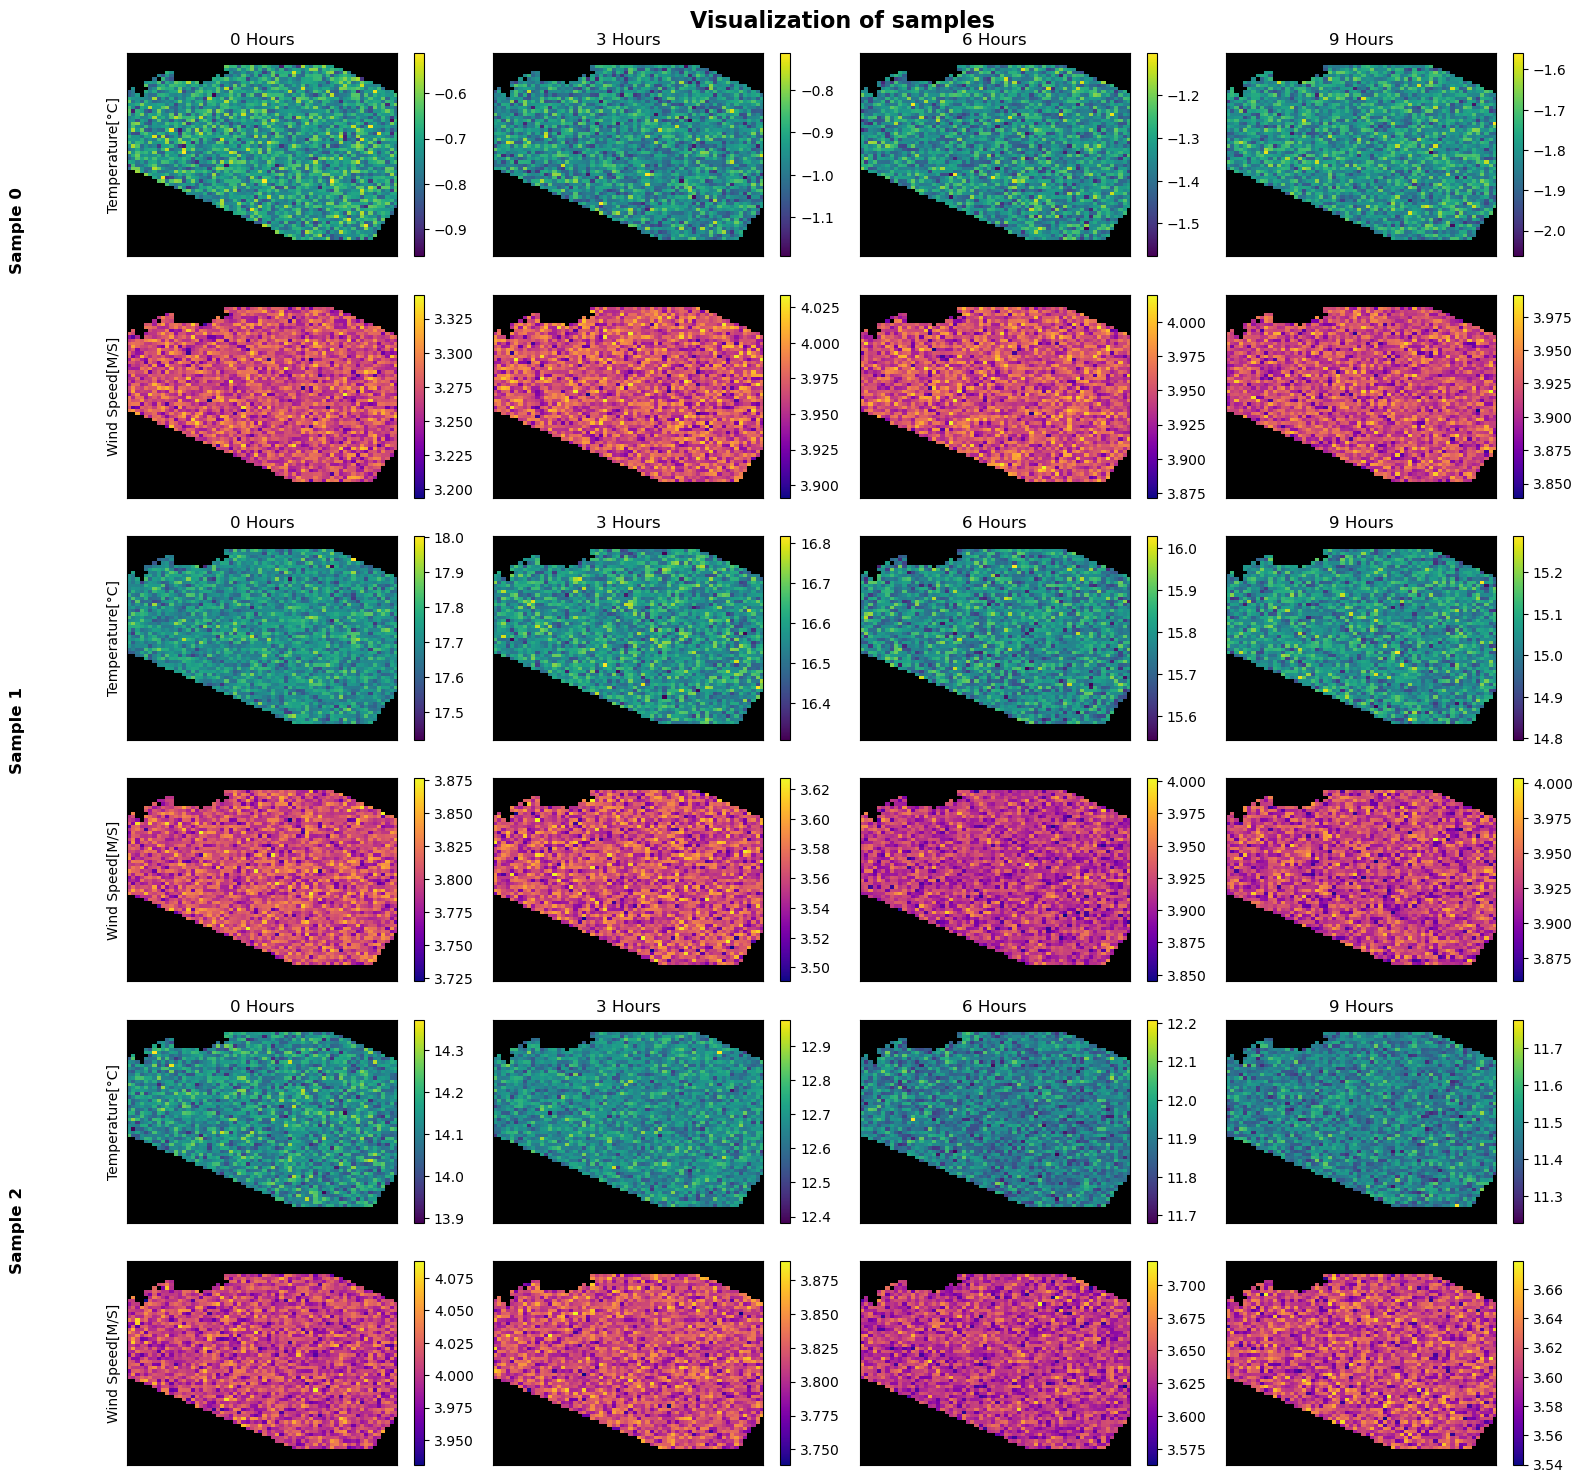

In [21]:
def A(x):
    return downscale(x,mask,64)
x_star, c_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = c_star['context'].to(device)
y_star = torch.normal(A(x_star), 1e-2)*mask

info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(y_star.detach().cpu(),info,mask_cpu,samples=3,step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1><bold>Visualization of Experience </bold> </h1>

In [22]:
importlib.reload(score)
sde = VPSDE(score.DPSGaussianScore(y_star,mask, A=A,  sde=vpsde, zeta=4.8), shape=x_star.shape).cuda()

In [23]:
x = sde.sample(mask,shape=(1,), c=c_star, steps=64, corrections=8, tau=0.5).cpu()


100%|███████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.46it/s]


torch.Size([15, 24, 64, 64])
T2m  Mean : -1.2730733156204224, Var: 0.9688423275947571
U10m  Mean : 3.8476955890655518, Var: 0.8986697196960449
T2m  Mean : -1.272935390472412, Var: 0.3739573359489441
U10m  Mean : 3.84773588180542, Var: 0.21637943387031555
T2m  Mean : -1.9910062551498413, Var: 0.805001974105835
U10m  Mean : 3.960742712020874, Var: 0.6707777976989746
T2m  Mean : 15.995772361755371, Var: 1.5099668502807617
U10m  Mean : 3.8448314666748047, Var: 1.3445502519607544
T2m  Mean : 15.995467185974121, Var: 0.8974739909172058
U10m  Mean : 3.8447959423065186, Var: 0.247441366314888
T2m  Mean : 15.595380783081055, Var: 0.6142697930335999
U10m  Mean : 3.9047882556915283, Var: 0.8023903965950012
T2m  Mean : 12.26595687866211, Var: 1.7575137615203857
U10m  Mean : 3.7369508743286133, Var: 1.5638777017593384
T2m  Mean : 12.265220642089844, Var: 0.884822428226471
U10m  Mean : 3.7370569705963135, Var: 0.13263386487960815
T2m  Mean : 11.76633358001709, Var: 0.8474575877189636
U10m  Mean : 3.

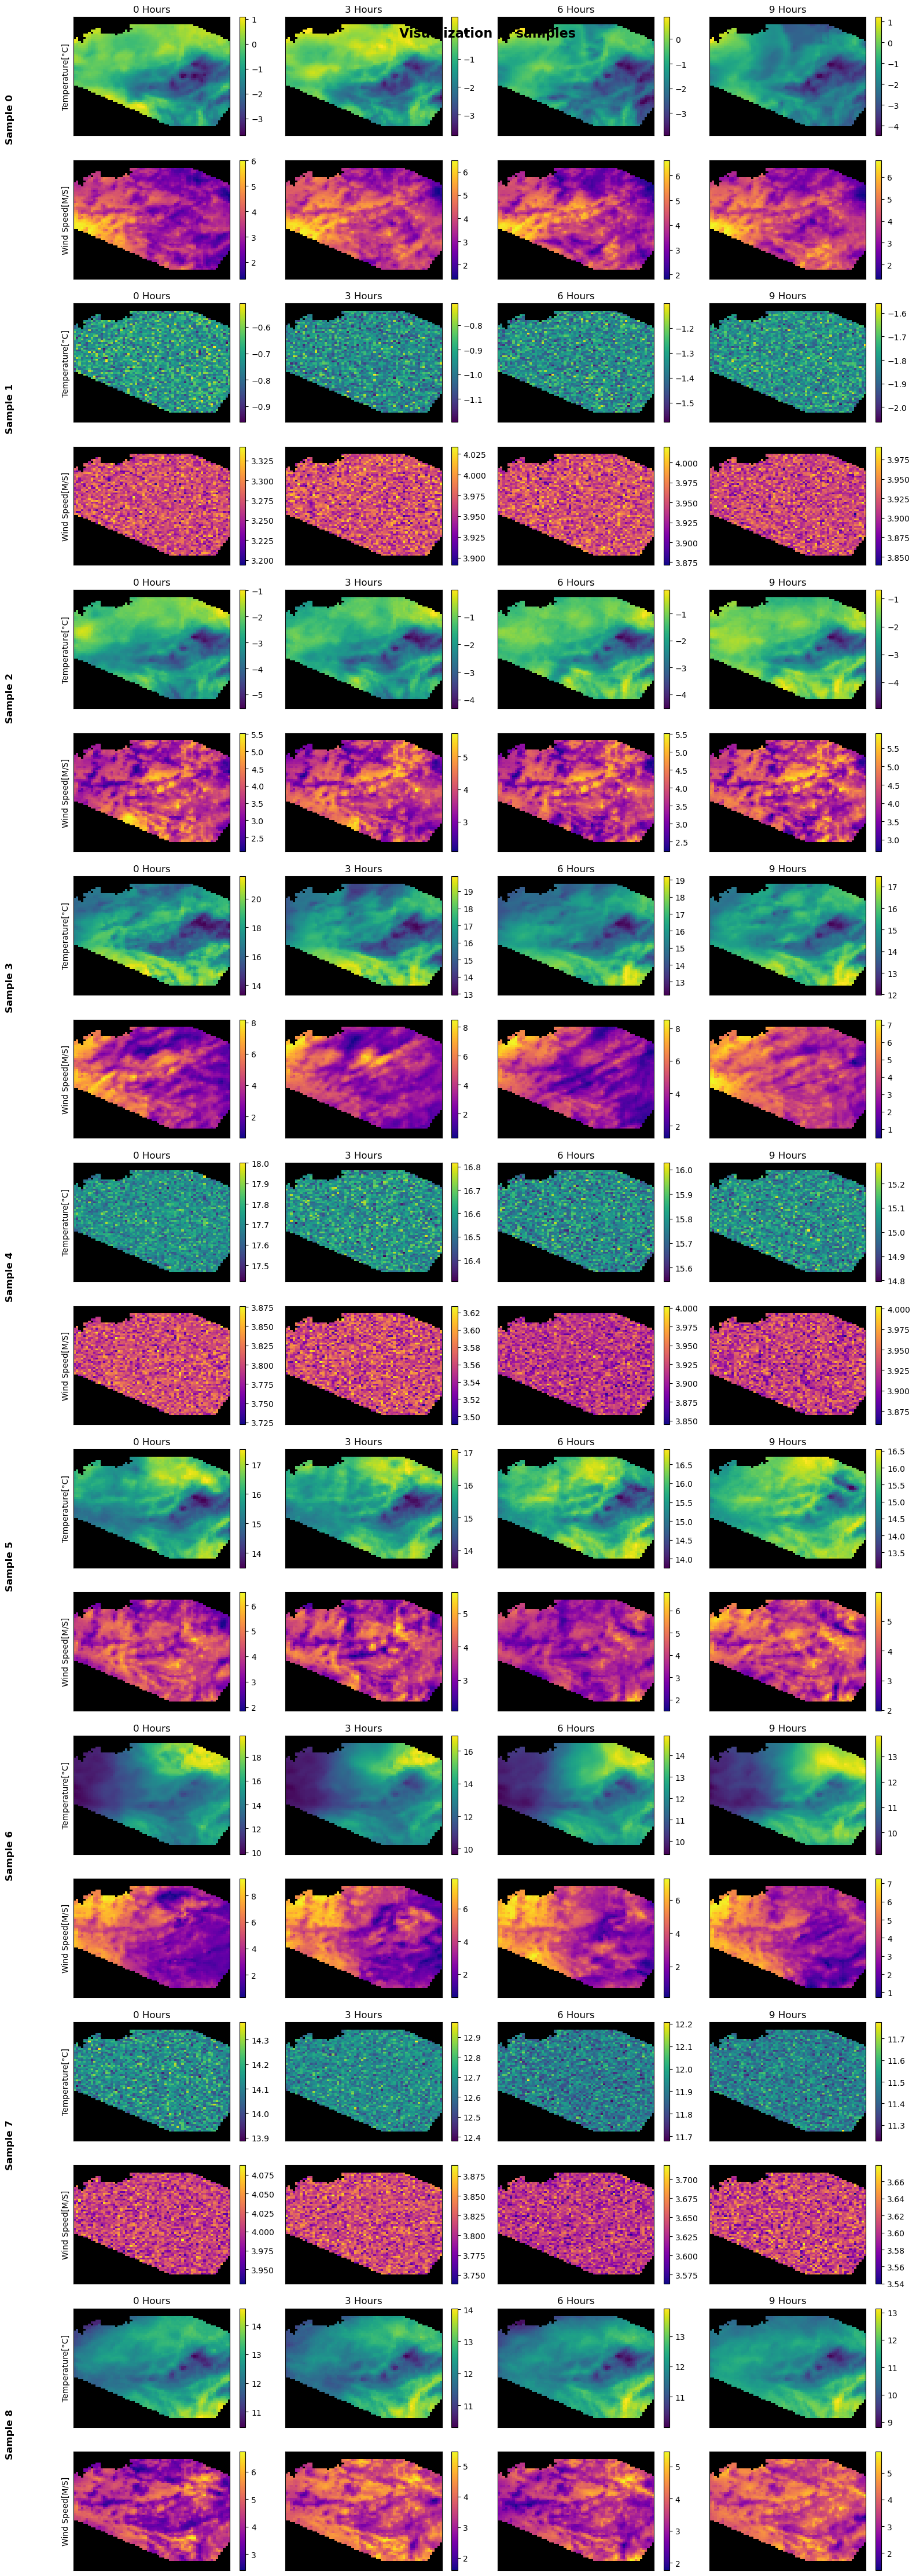

In [24]:
x_ = x[0]
# Good parameters : zeta: 4.5, steps: 48, corrections: 3
# zeta= 4.7, steps = 64, corrections = 8, tau = 0.5
new_tensor = torch.stack((x_star.detach().cpu(),y_star.detach().cpu(),x_), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)